In [2]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
from pandas.io.json import json_normalize
import datetime

In [1]:
##Dict of session:uri
FMlinkList = {'August':'https://www.commonsense.org/education/privacy/blog/digital-redlining-access-privacy',
        'September':'http://dmlcentral.net/speculative-design-for-emergent-learning-taking-risks/',
        'October':'http://marginalsyllab.us/wp-content/uploads/2016/08/PWFlow-Intro.pdf',
        'November':'https://helenbeetham.com/2016/11/14/ed-tech-and-the-circus-of-unreason/',
        'January':'http://marginalsyllab.us/the-school-and-social-progress-by-john-dewey/',
        'February':'http://marginalsyllab.us/preface-to-research-writing-rewired-lessons-that-ground-students-digital-learning-by-dawn-reed-and-troy-hicks/',
        'FebruaryJCI':'http://cognitionandinstruction.com/engagements-the-learning-sciences-in-a-new-era-of-u-s-nationalism/'}

In [4]:
##Create empty dataFrame, and append data scraped from annotation api
dfAllupdate = pd.DataFrame(columns=['created','document.title','group','id','links.html',
       'links.incontext','links.json','permissions.admin',
       'permissions.delete','permissions.read','permissions.update',
       'references','tags','target','text','updated','uri','user','session'])
for session,link in FMlinkList.items():
    df = scrapeAPI(session,link)
    dfAllupdate = dfAllupdate.append(df)
print('Total Records: ',len(dfAllupdate))

October
http://marginalsyllab.us/wp-content/uploads/2016/08/PWFlow-Intro.pdf
Number of Records Found for this Session:  166
Scraped:
0
20
40
60
80
100
120
140
160
166
January
http://marginalsyllab.us/the-school-and-social-progress-by-john-dewey/
Number of Records Found for this Session:  242
Scraped:
0
20
40
60
80
100
120
140
160
180
200
220
240
242
February
http://marginalsyllab.us/preface-to-research-writing-rewired-lessons-that-ground-students-digital-learning-by-dawn-reed-and-troy-hicks/
Number of Records Found for this Session:  121
Scraped:
0
20
40
60
80
100
120
121
September
http://dmlcentral.net/speculative-design-for-emergent-learning-taking-risks/
Number of Records Found for this Session:  87
Scraped:
0
20
40
60
80
87
FebruaryJCI
http://cognitionandinstruction.com/engagements-the-learning-sciences-in-a-new-era-of-u-s-nationalism/
Number of Records Found for this Session:  197
Scraped:
0
20
40
60
80
100
120
140
160
180
197
August
https://www.commonsense.org/education/privacy/b

In [6]:
#dateNow = datetime.datetime.now().strftime('%m%d%y_%H%M')
#print(dateNow)
#!mkdir $dateNow
textExtraction = pd.DataFrame(columns=['created','user','id','group','tags',
                              'text','references','target'])
for session in FMlinkList:
    print('Month: ',session)
    print('Total: ',len(dfAllupdate[dfAllupdate['session']==session]))
    print('Annotations: ',len(dfAllupdate[(dfAllupdate['session']==session
                                                  )&(dfAllupdate['references'].isnull())]))
    print('Replies: ',len(dfAllupdate[(dfAllupdate['session']==session
                                                  )&(dfAllupdate['references'].notnull())]))
    print('')
    #SNAnodes = dfAllupdate[dfAllupdate['session']==session].drop_duplicates(
    #    'user')['user'].str[5:].str[:-12].to_frame()
    #SNAnodes.reset_index(inplace=True,drop=True)
    #SNAnodes.rename(columns={'user':'Name'},inplace=True)
    
    reviewDataSet = dfAllupdate[dfAllupdate['session']==session
                           ][['created','user','id','group','tags',
                              'text','references','target']]
    if session is 'October':
        reviewDataSet['Anchor text'] = dfAllupdate[
            dfAllupdate['session']==session]['target'].map(lambda x: extractJSONOct(x[0]))
    else:
        reviewDataSet['Anchor text'] = dfAllupdate[
            dfAllupdate['session']==session]['target'].map(lambda x: extractJSON(x[0]))
    #reviewDataSet['Parent'] = np.where(reviewDataSet['references'].isnull(),True,False)
    #reviewDataSet['Child'] = np.where(reviewDataSet['references'].notnull(),True,False)
    reviewDataSet['created'] = reviewDataSet['created'].map(lambda x: x.strftime(
            '%m/%d/%Y %H:%M'))
    reviewDataSet['user'] = reviewDataSet['user'].str[5:].str[:-12]
    ##
    textExtraction = textExtraction.append(reviewDataSet)
    #SNALinks = dfAllupdate[dfAllupdate['session']==session][['id','user','references']]
    #SNALinks['Target'] = SNALinks['references'].map(
    #    lambda x: findUser(x[-1]),na_action='ignore')
    #SNALinks['Target'].fillna('Text',inplace=True)
    #SNALinks['Source'] = SNALinks['user'].str[5:].str[:-12]
    #SNALinks['Type'] = np.where(SNALinks['Target']=='Text','annotation','reply')
    #SNALinks['Directed'] = 1
    #sessionDir = dateNow + '/' + session
    #!mkdir $sessionDir
    #writer = pd.ExcelWriter(sessionDir+'/MarginalSyllabus'+session+'.xlsx')
    #SNAnodes.to_excel(writer,sheet_name='nodes',index=False)
    #SNALinks[['Source','Type','Target','Directed']].to_excel(writer,sheet_name='Relations',index=False)
    #reviewDataSet[['created','user','id','group',
    #               'tags','Anchor text','text',
    #               'Parent','Child']].to_excel(writer,sheet_name='DataReview',index=False)
    #writer.save()

Month:  October
Total:  166
Annotations:  103
Replies:  63

Month:  January
Total:  242
Annotations:  137
Replies:  105

Month:  February
Total:  121
Annotations:  43
Replies:  78

Month:  September
Total:  87
Annotations:  36
Replies:  51

Month:  FebruaryJCI
Total:  197
Annotations:  97
Replies:  100

Month:  August
Total:  190
Annotations:  53
Replies:  137

Month:  November
Total:  155
Annotations:  61
Replies:  94



In [61]:
dateNow = datetime.datetime.now().strftime('%m%d%y_%H%M')
print(dateNow)
!mkdir $dateNow
for session in FMlinkList:
    print('Month: ',session)
    print('Total: ',len(dfAllupdate[dfAllupdate['session']==session]))
    print('Annotations: ',len(dfAllupdate[(dfAllupdate['session']==session
                                                  )&(dfAllupdate['references'].isnull())]))
    print('Replies: ',len(dfAllupdate[(dfAllupdate['session']==session
                                                  )&(dfAllupdate['references'].notnull())]))
    print('')
    SNAnodes = dfAllupdate[dfAllupdate['session']==session].drop_duplicates(
        'user')['user'].str[5:].str[:-12].to_frame()
    SNAnodes.reset_index(inplace=True,drop=True)
    SNAnodes.rename(columns={'user':'Name'},inplace=True)
    
    reviewDataSet = dfAllupdate[dfAllupdate['session']==session
                           ][['created','user','id','group','tags',
                              'text','references','target']]
    if session is 'October':
        reviewDataSet['Anchor text'] = dfAllupdate[
            dfAllupdate['session']==session]['target'].map(lambda x: extractJSONOct(x[0]))
    else:
        reviewDataSet['Anchor text'] = dfAllupdate[
            dfAllupdate['session']==session]['target'].map(lambda x: extractJSON(x[0]))
    reviewDataSet['Parent'] = np.where(reviewDataSet['references'].isnull(),True,False)
    reviewDataSet['Child'] = np.where(reviewDataSet['references'].notnull(),True,False)
    reviewDataSet['created'] = reviewDataSet['created'].map(lambda x: x.strftime(
            '%m/%d/%Y %H:%M'))
    reviewDataSet['user'] = reviewDataSet['user'].str[5:].str[:-12]
    
    SNALinks = dfAllupdate[dfAllupdate['session']==session][['id','user','references']]
    SNALinks['Target'] = SNALinks['references'].map(
        lambda x: findUser(x[-1]),na_action='ignore')
    SNALinks['Target'].fillna('Text',inplace=True)
    SNALinks['Source'] = SNALinks['user'].str[5:].str[:-12]
    SNALinks['Type'] = np.where(SNALinks['Target']=='Text','annotation','reply')
    SNALinks['Directed'] = 1
    sessionDir = dateNow + '/' + session
    !mkdir $sessionDir
    writer = pd.ExcelWriter(sessionDir+'/MarginalSyllabus'+session+'.xlsx')
    SNAnodes.to_excel(writer,sheet_name='nodes',index=False)
    SNALinks[['Source','Type','Target','Directed']].to_excel(writer,sheet_name='Relations',index=False)
    reviewDataSet[['created','user','id','group',
                   'tags','Anchor text','text',
                   'Parent','Child']].to_excel(writer,sheet_name='DataReview',index=False)
    writer.save()

032817_1602
Month:  FebruaryJCI
Total:  197
Annotations:  97
Replies:  100



In [37]:
len(SNALinks['references'].map(lambda x: findUser(x[-1]),na_action='ignore'))

AqQAmABzEeeLHNvHc2BuJg
1
G2Motv7PEeaxeR8KQTWHvQ
2
ceC6Rv4CEeao6yOqy67IBA
3
1QDTWAAaEeeG4pM4RmtlCw
4
OtNGov_GEea5b69WCyzjHQ
5
t1G3qv_FEeajbBfdfuKkZg
6
8m0u8v-5EeaTrafnOqcvbw
7
6r14rP-zEeaxKfP15X4ucw
8
9u88VP-vEeahOVte-7KFqw
9
K9skLgA2EeekUBvM3J6aqQ
10
OtNGov_GEea5b69WCyzjHQ
11
HeCB7P3zEeaIUyulH7zB8Q
12
NBOyHP9hEeaTwlsyivIV5A
13
o4IfLP7KEealHwNW6ZMJaA
14
poZdav9fEealeKPDy9FyCA
15
-1T-FP4BEeaOe78-1sH7mg
16
-ZWPTgAYEeekOjPeHnhQvQ
17
IeHczP91Eeand59C9Ni_cw
18
LyTltP-2Eea851umsTh9Eg
19
C647vP6KEeav9duSvQUOig
20
ceC6Rv4CEeao6yOqy67IBA
21
ddXGFv3EEea4FJPYa3-MFw
22
zFDLuv4CEeaMTdM2660Mwg
23
HDxZNP0REea_l1-aKMViVg
24
J0qpaP0PEea1AT9NjrAgEQ
25
tACg-P0NEeaCJl_Rc3fYaA
26
ekziXv4CEeahkMvVw-LChg
27
wX3DQP4DEeahkq-F1muBMg
28
Q_ohEv9gEear2hubNjQTEg
29
LM_wEP4DEeayPusO7_LkNw
30
hDcfyP0SEealMv98FVE-_g
31
f5JBcv-EEeaK1Q8SkQeGSw
32
YwqEcP0SEeakvnsHwp03Zw
33
x_4Yuv-DEeaFpC8580fNvQ
34
foO73P6_Eeak7KeTkQ3RGQ
35
kvV8VP4BEeaEoitQDSQwqA
36
5FUBpv4AEea-Iqvp5S2PRQ
37
yLN_NP9bEeaJ2of-CS_HeA
38
jnCDPP9ZEea301sxV9134

197

In [37]:
dfAllupdate[dfAllupdate['session']=='October']['target'].map(lambda x: extractJSON(x[0]))

 “add up to a sense of mastery—or perhaps better, a sense of participation in determining the content of life”
Ambiguities, uncertainties, and unpredictably [sic] are the substance of teaching”
“why of teaching: why teaching methods work in particular ways in particular settings”
good teachers, novice and senior, live their class-room lives, maybe out of necessity, in a domain between principle and un-certainty”
 That which was once this is moving slowly—at least at first—toward becoming tha
These texts routinely problematize that alluring notion that there’s a set of best-practice teaching methods some-where out there that are so foolproof they should come with a money-back guarantee.
showed more significant gains in their ELA growth than any of the seniors Antero had taught previously
as the art emerges, they may make countless adjustments and new decisions that result in a product they probably didn’t imagine from the start
relaxing the muscles that are stretching and the muscles th

2017-03-14 23:24:44.306901-06:00    None
2017-03-14 23:23:27.996906-06:00    None
2017-03-14 23:19:23.568041-06:00    None
2017-03-14 23:14:02.437704-06:00    None
2017-03-14 23:11:35.247609-06:00    None
2017-03-14 23:07:41.255416-06:00    None
2017-03-14 22:58:52.881303-06:00    None
2017-02-20 14:02:27.421490-07:00    None
2017-02-20 13:55:57.516856-07:00    None
2017-02-20 13:47:21.324612-07:00    None
2017-02-20 13:40:47.059031-07:00    None
2017-02-20 13:35:33.424810-07:00    None
2017-02-19 18:45:08.789405-07:00    None
2017-02-19 13:34:32.040037-07:00    None
2017-02-19 12:07:46.815722-07:00    None
2017-02-19 12:03:10.492021-07:00    None
2017-02-19 11:57:13.041729-07:00    None
2017-02-19 11:51:38.064539-07:00    None
2017-02-18 20:25:37.005005-07:00    None
2017-02-18 20:18:52.726826-07:00    None
2017-02-18 20:11:59.497889-07:00    None
2017-02-18 20:03:36.888936-07:00    None
2017-02-18 19:57:10.519085-07:00    None
2017-02-18 12:13:02.967935-07:00    None
2017-02-18 10:34

In [5]:
#Finds anchor text 'exact' in json
def extractJSONOct(row):#for Oct
    if len(row) > 1:
        return row['selector'][1]['exact']
    else:
        return np.NaN
def extractJSON(row):#for months except Oct
    if len(row) > 1:
        return row['selector'][3]['exact']
    else:
        return np.NaN
def findUser(ref):
    #return dfAllupdate[dfAllupdate['id']==ref]['user'].str[5:].str[:-12][0]
    if len(SNALinks[SNALinks['id'] == ref]) is 0:
        return np.NaN
    else:
        return SNALinks[SNALinks['id']==ref]['user'].str[5:].str[:-12][0]

In [55]:
if len(SNALinks[SNALinks['id'] == '2Zgv6v6MEeaoRV9HCrnxfg']) is 1:

In [7]:
dateNow = datetime.datetime.now().strftime('%m%d%y_%H%M')
print(dateNow)
!mkdir $dateNow
for session in FMlinkList:
    Table1 = pd.DataFrame(index=list(dfAllupdate[dfAllupdate['session'] == session
                                            ].drop_duplicates('user')['user']))
    Table1['annotations'] = dfAllupdate[(dfAllupdate['session'] == session)&
                                (dfAllupdate['references'].isnull())
                               ].groupby('user').size()
    Table1['replies'] = dfAllupdate[(dfAllupdate['session'] == session)&
                                (~dfAllupdate['references'].isnull())
                               ].groupby('user').size()
    Table1.fillna(0,inplace=True)
    Table1.index = Table1.index.str[5:].str[:-12]
    Table1['total'] = Table1['replies'] + Table1['annotations']
    Table1.name = 'Table1'
    Graph1 = Table1.T
    Graph1.name = 'Graph1'
    
    Graph3 = dfAllupdate[(dfAllupdate['session'] == session)
                                ].groupby([pd.TimeGrouper('15T'),'user']).size().to_frame()
    Graph3.reset_index(level='user',inplace=True)
    Graph3 = pd.pivot_table(Graph3,columns='user',values=0,
                                         index=pd.Grouper(freq='15T'),fill_value=0)
    Graph3 = Graph3.rename(columns=lambda x: x[5:][:-12])
    Graph3.name = 'Graph3'

    graphEntireConversation = dfAllupdate[(dfAllupdate['session'] == session)
                                ].groupby([pd.TimeGrouper('D'),'user']).size().to_frame()
    graphEntireConversation.reset_index(level='user',inplace=True)
    graphEntireConversation['Total'] = graphEntireConversation.sum(axis=1)
    graphEntireConversation = pd.pivot_table(graphEntireConversation,columns='user',values=0,
                                         index=pd.Grouper(freq='D'),fill_value=0)
    graphEntireConversation = graphEntireConversation.rename(columns=lambda x: x[5:][:-12])
    graphEntireConversation['Total'] = graphEntireConversation.sum(axis=1)
    graphEntireConversation.name = 'graphEntireConversation'
    
    sessionDir = dateNow + '/' + session
    saveList = [Table1,Graph1,Graph3,graphEntireConversation]
    !mkdir $sessionDir
    print(sessionDir)
    for file in saveList:
        print(sessionDir + '/' + file.name + '.csv')
        print(sessionDir + '/' + file.name + '.pkl')
        file.to_csv(sessionDir + '/' + file.name + '.csv')
        file.to_pickle(sessionDir + '/' + file.name + '.pkl')

032817_1432
032817_1432/FebruaryJCI
032817_1432/FebruaryJCI/Table1.csv
032817_1432/FebruaryJCI/Table1.pkl
032817_1432/FebruaryJCI/Graph1.csv
032817_1432/FebruaryJCI/Graph1.pkl
032817_1432/FebruaryJCI/Graph3.csv
032817_1432/FebruaryJCI/Graph3.pkl
032817_1432/FebruaryJCI/graphEntireConversation.csv
032817_1432/FebruaryJCI/graphEntireConversation.pkl


In [12]:
dfAllupdate.head()

,created,document.title,group,id,links.html,links.incontext,links.json,permissions.admin,permissions.delete,permissions.read,permissions.update,references,tags,target,text,updated,uri,user,session
2017-03-07 17:26:49.231482-07:00,2017-03-08 00:26:49.231482,[Engagements: The Learning Sciences in a New E...,__world__,62-OngOVEeeODRv0IZXVvA,https://hypothes.is/a/62-OngOVEeeODRv0IZXVvA,https://hyp.is/62-OngOVEeeODRv0IZXVvA/cognitio...,https://hypothes.is/api/annotations/62-OngOVEe...,[acct:KayteeTaylor@hypothes.is],[acct:KayteeTaylor@hypothes.is],[group:__world__],[acct:KayteeTaylor@hypothes.is],NaN,[],[{'selector': [{'conformsTo': 'https://tools.i...,Thank you for situating our national nightmare...,2017-03-08 00:26:49.231482,http://cognitionandinstruction.com/engagements...,acct:KayteeTaylor@hypothes.is,FebruaryJCI
2017-03-05 07:30:36.788339-07:00,2017-03-05 14:30:36.788339,[Engagements: The Learning Sciences in a New E...,__world__,TIteKgGwEeec6qMRmCIImA,https://hypothes.is/a/TIteKgGwEeec6qMRmCIImA,https://hyp.is/8m0u8v-5EeaTrafnOqcvbw/cognitio...,https://hypothes.is/api/annotations/TIteKgGwEe...,[acct:Caro@hypothes.is],[acct:Caro@hypothes.is],[group:__world__],[acct:Caro@hypothes.is],"[8m0u8v-5EeaTrafnOqcvbw, AqQAmABzEeeLHNvHc2BuJg]",[],[{'source': 'http://cognitionandinstruction.co...,It is - thank you for creating this type of sp...,2017-03-05 14:30:36.788339,http://cognitionandinstruction.com/engagements...,acct:Caro@hypothes.is,FebruaryJCI
2017-03-03 21:39:44.299406-07:00,2017-03-04 04:39:44.299406,[Engagements: The Learning Sciences in a New E...,__world__,ltKKAgCUEeehbsNd7OalZw,https://hypothes.is/a/ltKKAgCUEeehbsNd7OalZw,https://hyp.is/ltKKAgCUEeehbsNd7OalZw/cognitio...,https://hypothes.is/api/annotations/ltKKAgCUEe...,[acct:nicole.louie@hypothes.is],[acct:nicole.louie@hypothes.is],[group:__world__],[acct:nicole.louie@hypothes.is],NaN,[],[{'selector': [{'conformsTo': 'https://tools.i...,I'm glad to see this section on teaching. The ...,2017-03-04 04:39:44.299406,http://cognitionandinstruction.com/engagements...,acct:nicole.louie@hypothes.is,FebruaryJCI
2017-03-03 21:31:40.206512-07:00,2017-03-04 04:31:40.206512,[Engagements: The Learning Sciences in a New E...,__world__,dkGBIgCTEee26l8pLZDVOg,https://hypothes.is/a/dkGBIgCTEee26l8pLZDVOg,https://hyp.is/0AR2aP0HEealFcN4uSOCnQ/cognitio...,https://hypothes.is/api/annotations/dkGBIgCTEe...,[acct:nicole.louie@hypothes.is],[acct:nicole.louie@hypothes.is],[group:__world__],[acct:nicole.louie@hypothes.is],"[0AR2aP0HEealFcN4uSOCnQ, G2Motv7PEeaxeR8KQTWHvQ]",[],[{'source': 'http://cognitionandinstruction.co...,"Yes, but let's not be too quick to pat ourselv...",2017-03-04 04:31:40.206512,http://cognitionandinstruction.com/engagements...,acct:nicole.louie@hypothes.is,FebruaryJCI
2017-03-03 21:19:46.020346-07:00,2017-03-04 04:19:46.020346,[Engagements: The Learning Sciences in a New E...,__world__,zJeppACREeebQFv_w1BAXw,https://hypothes.is/a/zJeppACREeebQFv_w1BAXw,https://hyp.is/zJeppACREeebQFv_w1BAXw/cognitio...,https://hypothes.is/api/annotations/zJeppACREe...,[acct:nicole.louie@hypothes.is],[acct:nicole.louie@hypothes.is],[group:__world__],[acct:nicole.louie@hypothes.is],NaN,[],[{'selector': [{'conformsTo': 'https://tools.i...,It strikes me that we need to have more explic...,2017-03-04 04:19:46.020346,http://cognitionandinstruction.com/engagements...,acct:nicole.louie@hypothes.is,FebruaryJCI


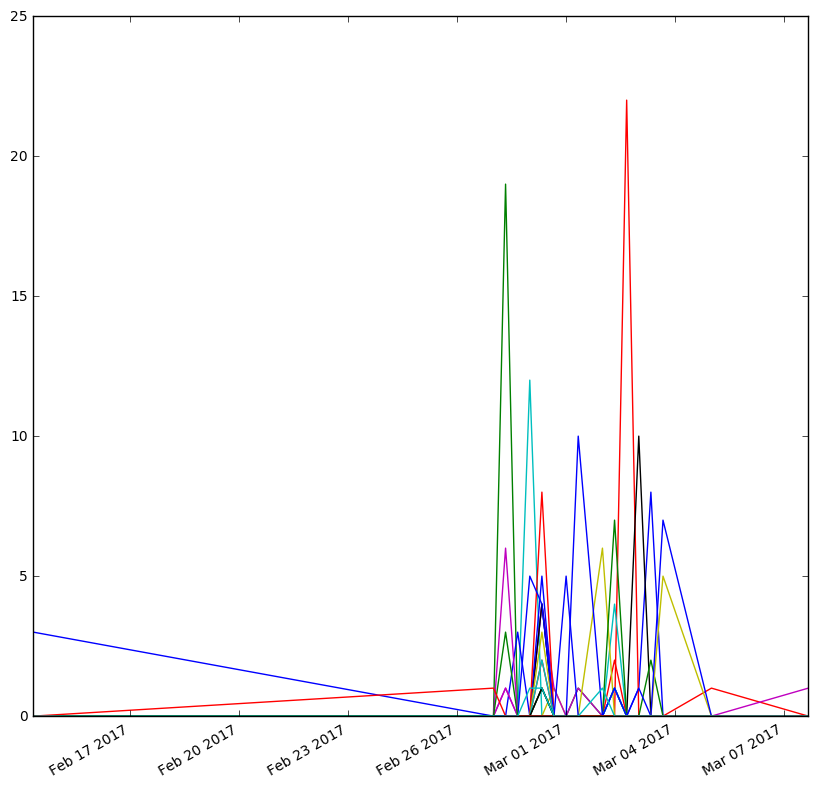

In [10]:
tmp = dfAllupdate[(dfAllupdate['session'] == session)
                                ].groupby([pd.TimeGrouper('8H'),'user']).size().to_frame()
tmp.reset_index(level='user',inplace=True)
tmp = pd.pivot_table(tmp,columns='user',values=0,
                                         index=pd.Grouper(freq='8H'),fill_value=0)
tmp = tmp.rename(columns=lambda x: x[5:][:-12])
tmp.plot(legend=False,figsize=(10,10))

In [11]:
tmp.to_csv('CnI-8hr.csv')

In [7]:
#Monthly Annotations, revisions and percentage of each
for revMonth in FMlinkList:
    revisions = len(dfAllupdate[(dfAllupdate['session'] == revMonth)&
          (dfAllupdate['updated'] - dfAllupdate['created'] > pd.Timedelta(1,unit='s'))])
    totalAnnotations = len(dfAllupdate[dfAllupdate['session'] == revMonth])
    revPercent = (revisions / totalAnnotations) * 100
    print('month:\t\t',revMonth)
    print('revisions:\t',revisions)
    print('total:\t\t',totalAnnotations)
    print('percent:\t',revPercent)
    print('')

month:		 FebruaryJCI
revisions:	 21
total:		 197
percent:	 10.65989847715736



In [3]:
def scrapeAPI(session,uri):
    n = 0
    payload = {'url':uri}
    r = requests.get('https://hypothes.is/api/search',params=payload)
    df = pd.DataFrame(columns=['created', 'document.title', 'group', 'id', 'links.html',
       'links.incontext', 'links.json', 'permissions.admin',
       'permissions.delete', 'permissions.read', 'permissions.update',
       'references', 'tags', 'target', 'text', 'updated', 'uri', 'user'])
    total = r.json()['total']
    print(session)
    print(uri)
    print('Number of Records Found for this Session: ',total)
    print('Scraped:')
    while n < total:
        print(n)
        df = df.append(json_normalize(r.json()['rows']))
        n = len(df)
        payload = {
            'url':uri,
            'offset':n}
        r = requests.get('https://hypothes.is/api/search',params=payload)
    print(n)
    df['session'] = session
    df['updated'] = pd.to_datetime(df['updated'])
    df['created'] = pd.to_datetime(df['created'])
    df = df.set_index(df['created'])
    df.index = df.index.tz_localize('UTC').tz_convert('US/Mountain')
    return df

In [15]:
print(dfAllupdate.nsmallest(5,'created')[['id','user']])
print(dfAllupdate.nlargest(5,'created')[['id','user']])

                                                      id  \
2017-02-14 14:00:58.687578-07:00  r0TDYPL4EeaRWFeeVNbHqg   
2017-02-14 14:14:32.071961-07:00  lBYvtPL6EeaJ40fxQpK50g   
2017-02-14 14:34:07.307671-07:00  UJSP5PL9EeaybLeGtLlLLg   
2017-02-27 06:43:07.011209-07:00  q3ztHPzyEea7MpOPTxdtPA   
2017-02-27 08:52:25.502521-07:00  u-uIkP0EEealEy-D9ZoT5g   

                                                        user  
2017-02-14 14:00:58.687578-07:00  acct:remikalir@hypothes.is  
2017-02-14 14:14:32.071961-07:00  acct:remikalir@hypothes.is  
2017-02-14 14:34:07.307671-07:00  acct:remikalir@hypothes.is  
2017-02-27 06:43:07.011209-07:00     acct:suzank@hypothes.is  
2017-02-27 08:52:25.502521-07:00      acct:BMBOD@hypothes.is  
                                                      id  \
2017-03-07 17:26:49.231482-07:00  62-OngOVEeeODRv0IZXVvA   
2017-03-05 07:30:36.788339-07:00  TIteKgGwEeec6qMRmCIImA   
2017-03-03 21:39:44.299406-07:00  ltKKAgCUEeehbsNd7OalZw   
2017-03-03 21:31:40.2

In [21]:
#To find first and last in a session
print(dfAllupdate[dfAllupdate['session'] == 'September'].nsmallest(1,'created')[['id','user']])
print(dfAllupdate[dfAllupdate['session'] == 'September'].nlargest(1,'created')[['id','user']])
##For the created/updated bug in API
updatedAnnotationCounts = [(len(dfAllupdate[(dfAllupdate['session'] == 'August')]),
                          len(dfAllupdate[(dfAllupdate['session'] == 'August')&
      (dfAllupdate['updated'] - dfAllupdate['created']
       > pd.Timedelta(1,unit='s'))]))]
Graph2 = pd.DataFrame(data=updatedAnnotationCounts,columns=['annotations','updated'])
Graph2 = Graph2.T
Graph2.rename(columns={0:'August'},inplace=True)
Graph2.plot.pie(y='August')
Graph2.to_csv('data/Graph2.csv')
Graph2.to_pickle('data/Graph2.pkl')

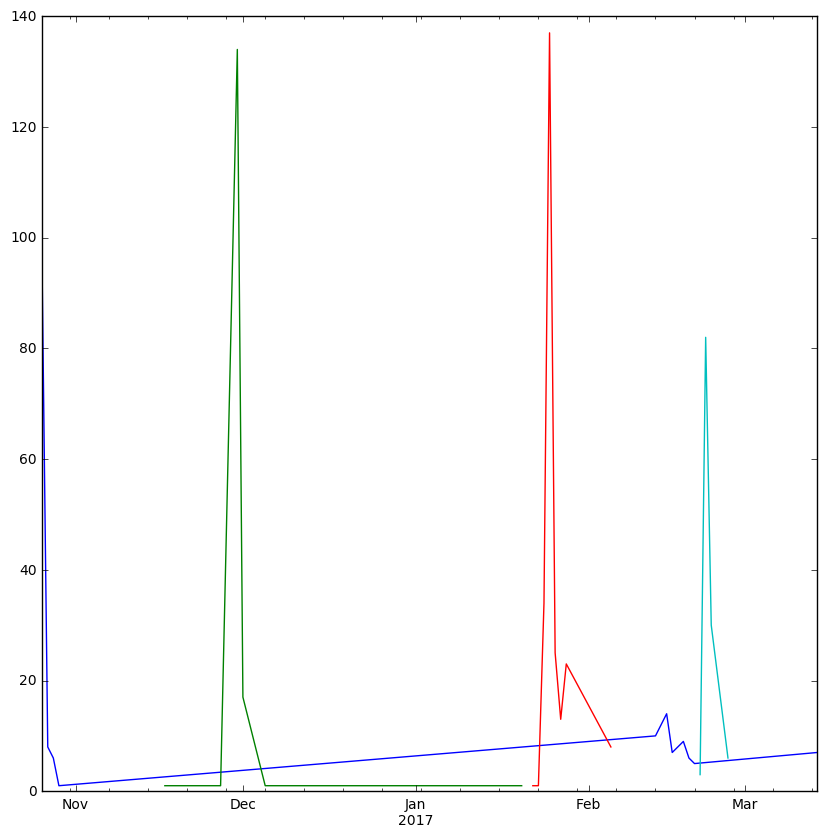

In [214]:
tmp4 = pd.read_pickle('032217_1353/February/graphEntireConversation.pkl')
tmp['Total'].plot(legend=False,figsize=(10,10))
tmp2['Total'].plot(legend=False,figsize=(10,10))
tmp3['Total'].plot(legend=False,figsize=(10,10))
tmp4['Total'].plot(legend=False,figsize=(10,10))